# Fraud Detection

With the advent of **digitalization** of all personal data **cybersecurtiy** has become one of the most important facets in computer science. One way to improve and scale cybersecurity or should I say the only way is to use Machine Learning. One of the methods of data protection include fraud detection. In this notebook I will show you  a couple of ways in which we can implement fraud detection.<br>
<br>
Let's start by importing all the requisites.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)

We will be using [kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset of credit card transactions for fraud detection.

In [2]:
df = pd.read_csv('creditcard.csv', low_memory=False)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,131069.0,1.914457,-1.169212,-1.088971,-0.433338,0.016041,1.514971,-0.808005,0.389147,-0.066826,...,-0.626125,-0.941652,0.322765,-1.623495,-0.472809,0.501906,0.013214,-0.076335,49.22,0
1,136835.0,-0.210098,1.025595,0.169418,-0.659175,0.505506,-1.030557,0.991612,-0.191814,0.080130,...,-0.283524,-0.545005,0.073812,-0.080948,-0.426185,0.150863,0.357840,0.163793,2.69,0
2,81063.0,-1.451195,1.602318,0.781360,-0.113021,-0.649286,-0.293276,-0.095660,1.038845,-0.868248,...,-0.079988,-0.351767,0.140502,0.209505,-0.213920,0.079557,0.151493,0.029914,26.99,0
3,142388.0,-1.094805,1.056097,-0.073260,-1.815095,0.520099,-1.318499,1.480056,0.143702,-1.282953,...,0.218751,0.259110,-0.444524,0.086208,0.981687,1.442265,-0.321032,-0.070678,58.00,0
4,84728.0,-5.421252,-3.185555,1.245214,-1.258292,-0.023492,0.071031,-1.193202,-3.193528,2.607383,...,2.192130,-0.072944,1.328140,0.338707,1.093268,0.267037,0.917337,0.298255,200.00,0


## Data visualization

In this dataset, the only attributes that can be visualized are time and amount. So let'e see if we can draw any pattern for fraudulent transaction from these two attributes.<br>
Check to see if there are any **NULL** values.

In [3]:
df.isnull().values.any() #check to see if any values are null, which there are not

False

Now we have to check the number of fraudulent and non-fraudulent transactions.

In [4]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

Yikes!! Clearly this is an unbalanced dataset. So what we can think about doing here is some sort of anomaly detection. We will see this later!<br>
For now let's get a visual confiramtion of this unbalanced dataset and also the distribution of the same.

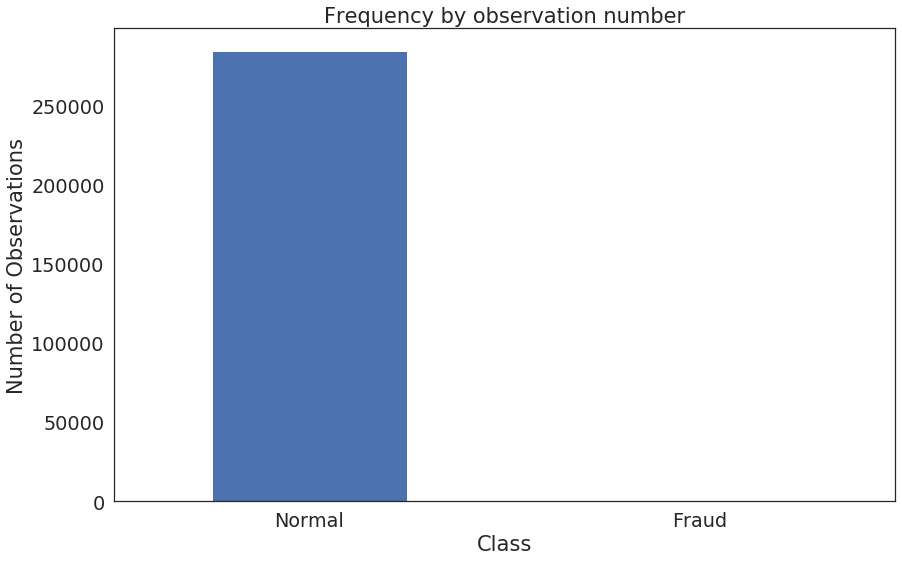

In [16]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")
plt.show()

In [17]:
non_fraud = df[df.Class == 0]
fraud = df[df.Class == 1]

In [18]:
non_fraud.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [19]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Although the mean is a little higher in the fraud transactions, it is certainly within a standard deviation and so is unlikely to be easy to discriminate in a highly precise manner between the classes with pure statistical methods.<br>
Let's explore the transaction amount data a little more.

/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


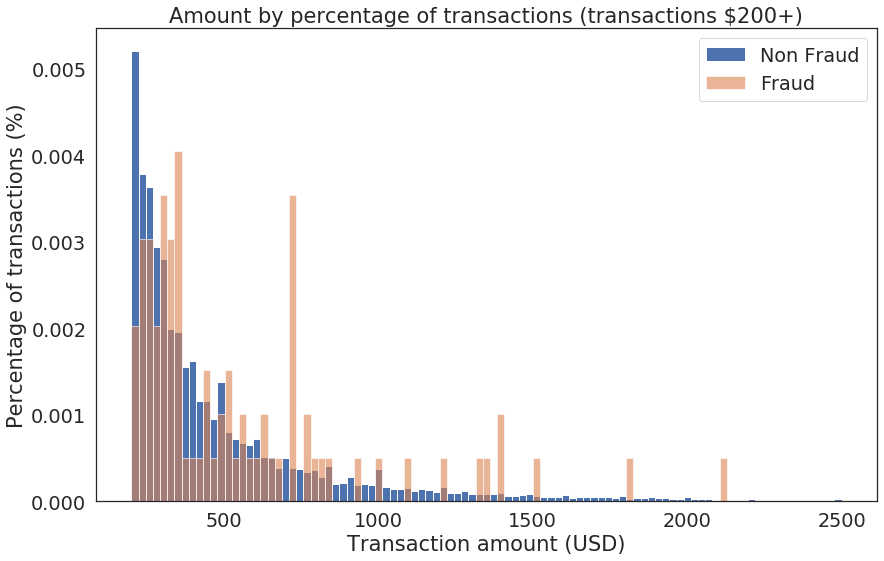

In [21]:
#plot of high value transactions (say above $200)
bins = np.linspace(200, 2500, 100)
plt.hist(non_fraud.Amount, bins, alpha=1, normed=True, label='Non Fraud')
plt.hist(fraud.Amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

The transaction amount does not look very informative.
Next we will visualize the data by hour.<br>
Note: zero hour corresponds to the hour of first transaction. Not any time of the day.

/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


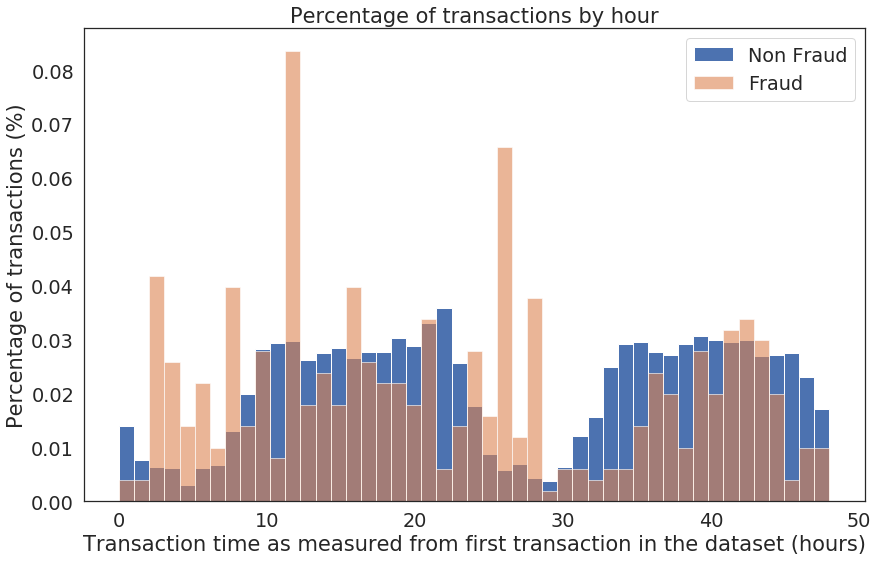

In [22]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((non_fraud.Time/(60*60)), bins, alpha=1, normed=True, label='Non Fraud')
plt.hist((fraud.Time/(60*60)), bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

As it can be seen, there's a heavy decrese in normal transactions between hours 1 to 8 and again at hours 24 to 32. However, the potential time offset between fraudulent and non-fraudulent transactions is not enough to make a simple classifier.

Visual Exploration of transaction amount vs hour.

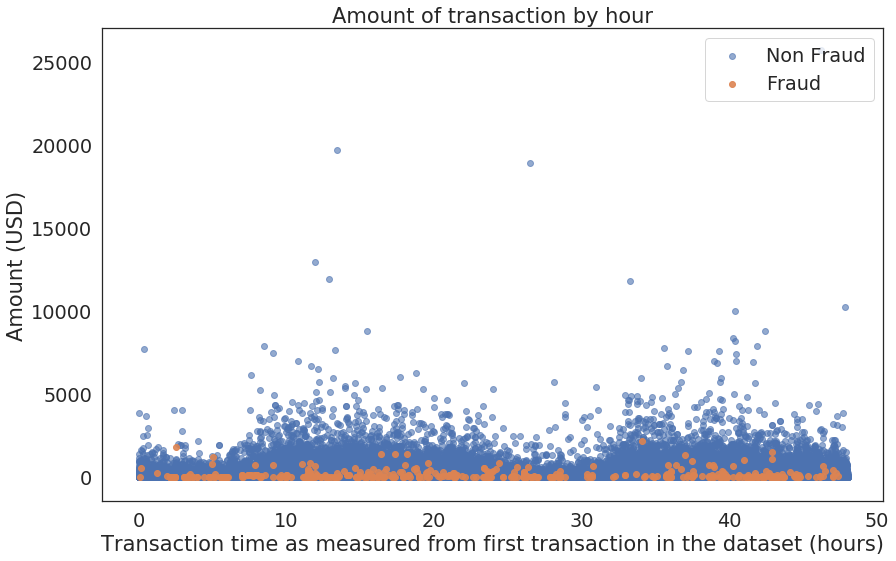

In [24]:
plt.scatter((non_fraud.Time/(60*60)), non_fraud.Amount, alpha=0.6, label='Non Fraud')
plt.scatter((fraud.Time/(60*60)), fraud.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

Again, this is not enough to make a good classifier.<br>
Here are some other plots of all features that you can visualize.

Text(0.5, 1.0, 'Amount Distribution for fraud and non-fraudulent transactions')

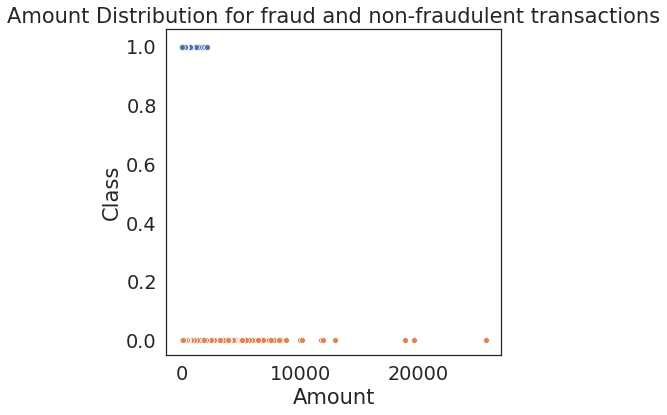

In [26]:
# Plot 1
plt.figure(figsize=(6,6))
ax = sns.scatterplot(x='Amount', y='Class', data=fraud)
sns.scatterplot(x='Amount', y='Class', data=non_fraud, ax=ax)
ax.set_title('Amount Distribution for fraud and non-fraudulent transactions')

In [28]:
features = ['Time','Amount'] + ['V%d' % num for num in range(1,29)]
target = ['Class']
X = df[features]
y = df[target]

### Distribution of all features

/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


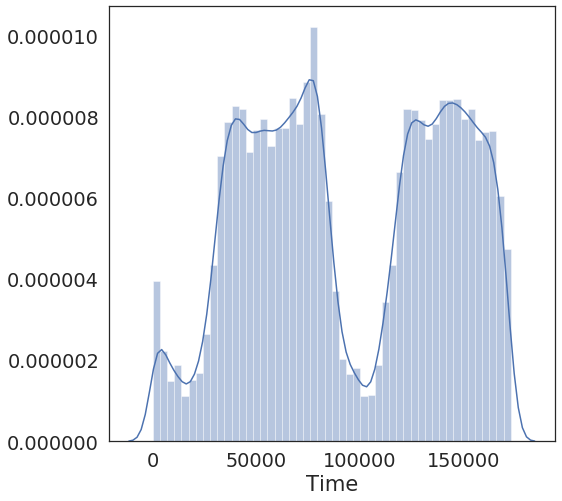

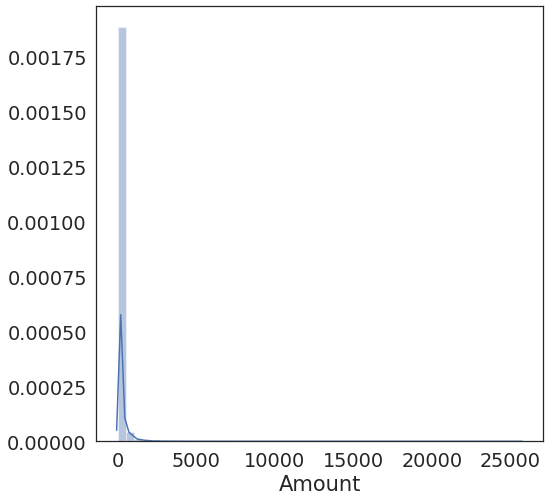

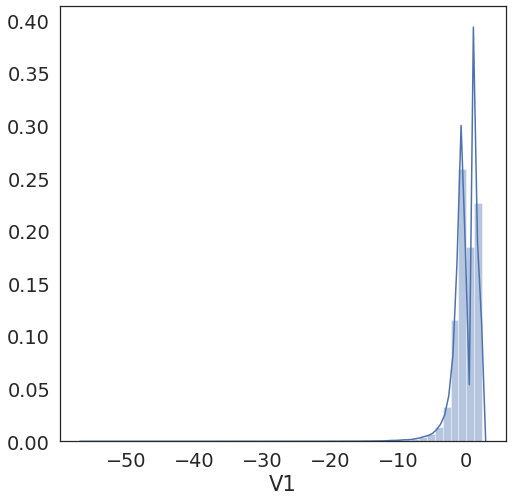

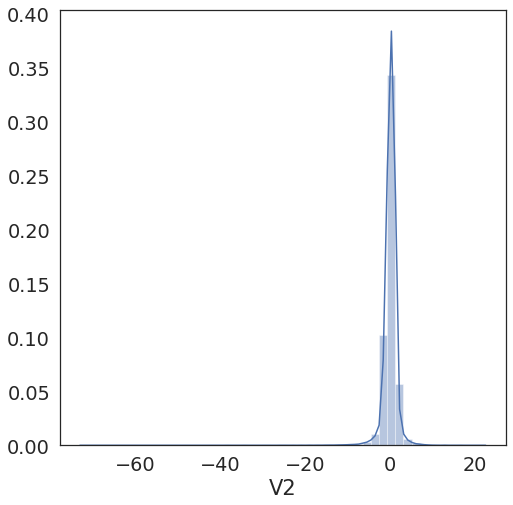

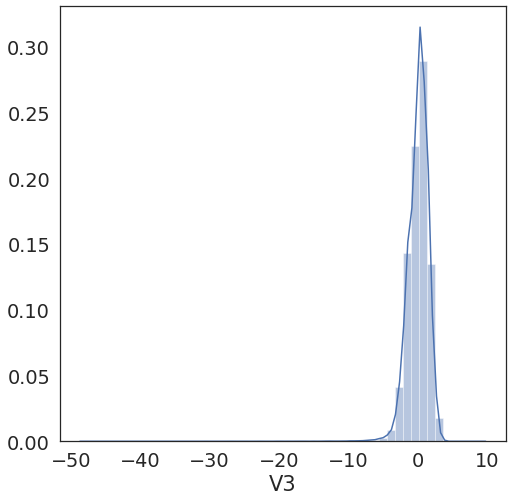

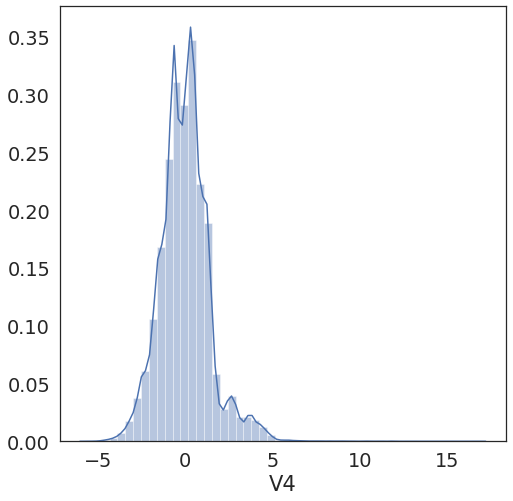

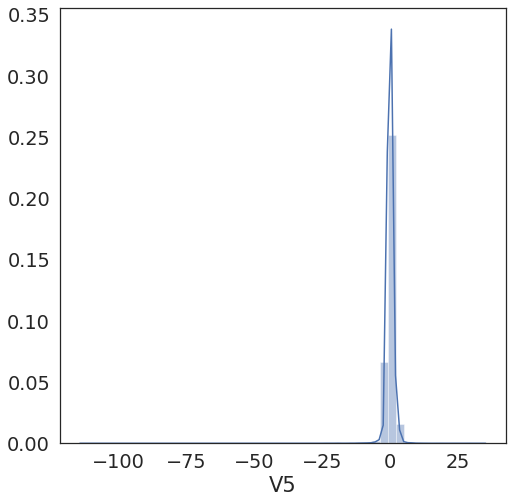

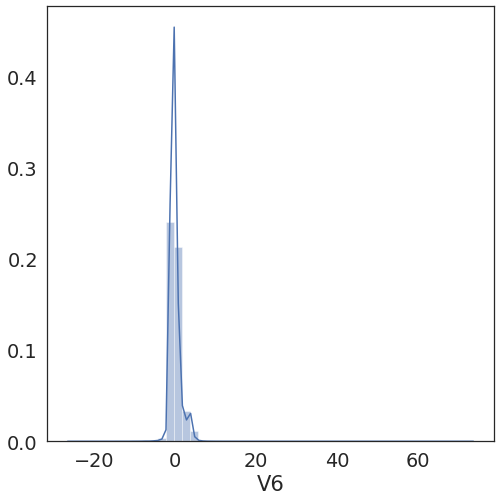

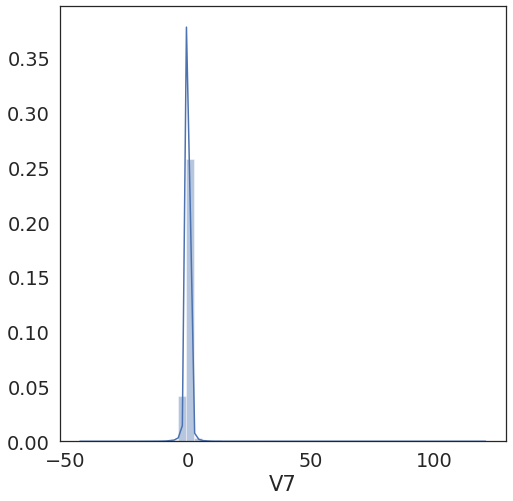

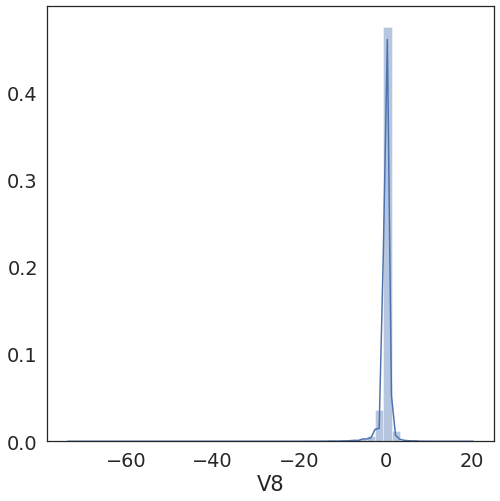

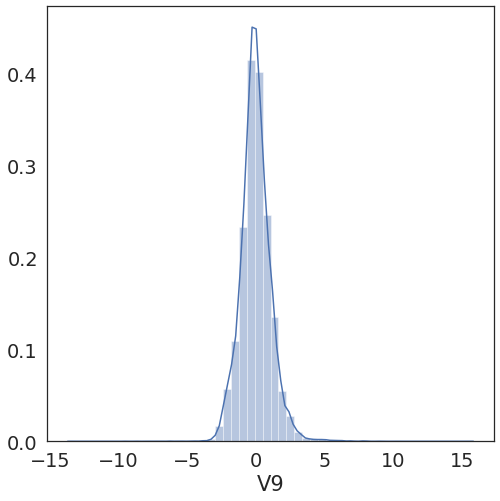

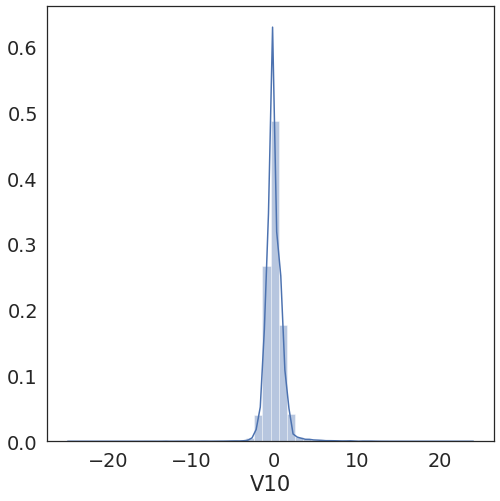

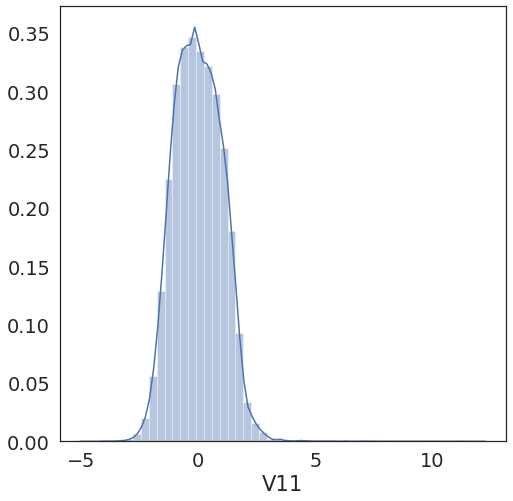

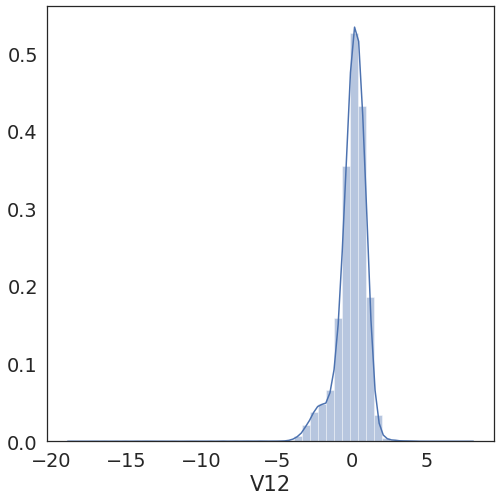

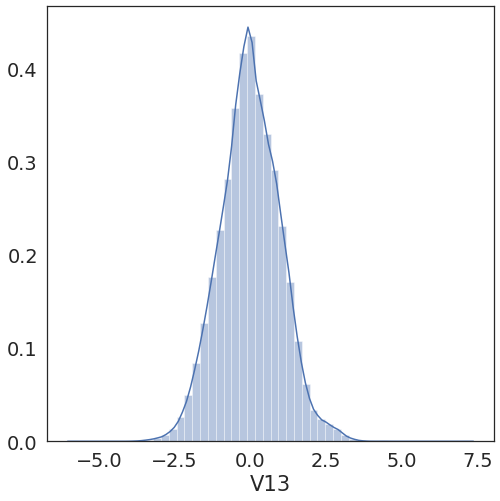

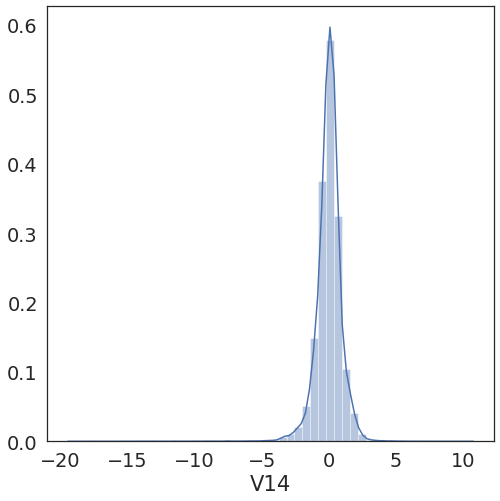

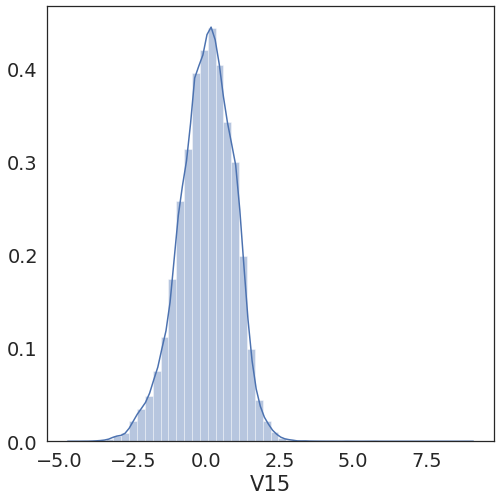

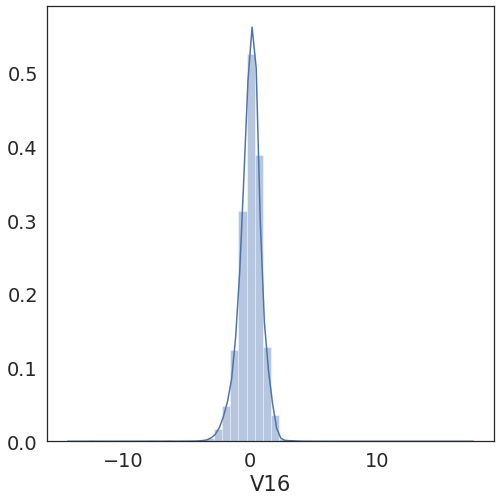

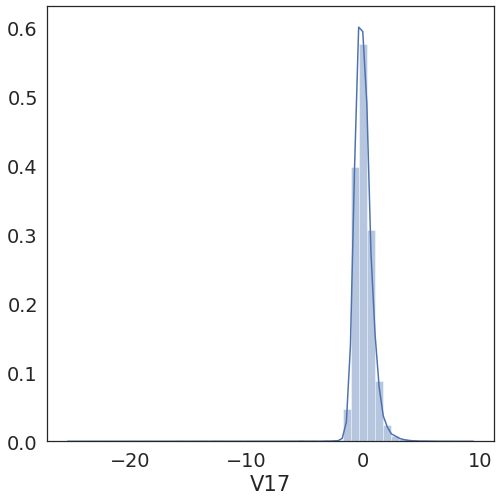

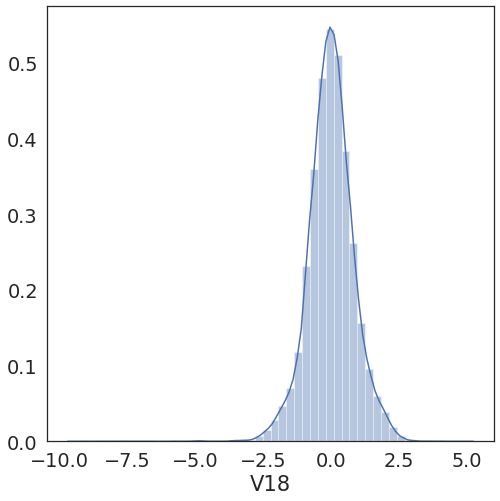

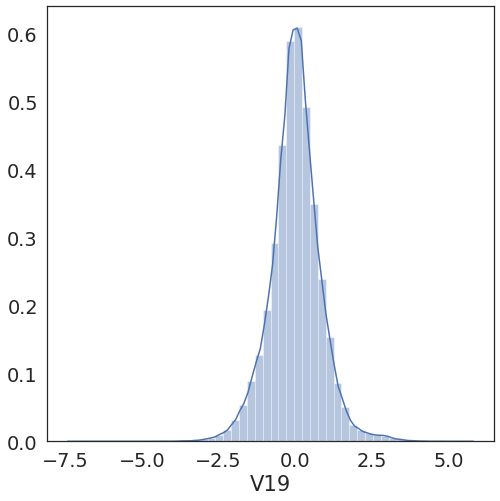

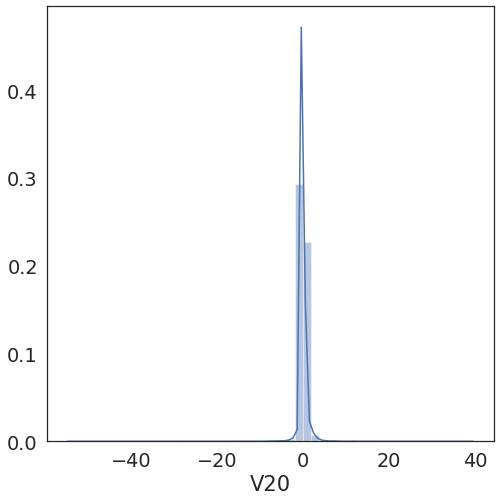

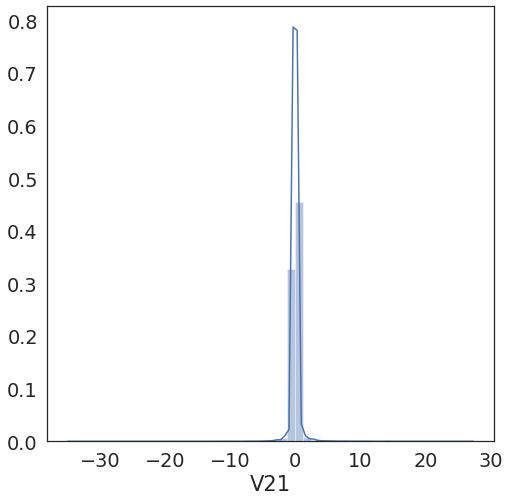

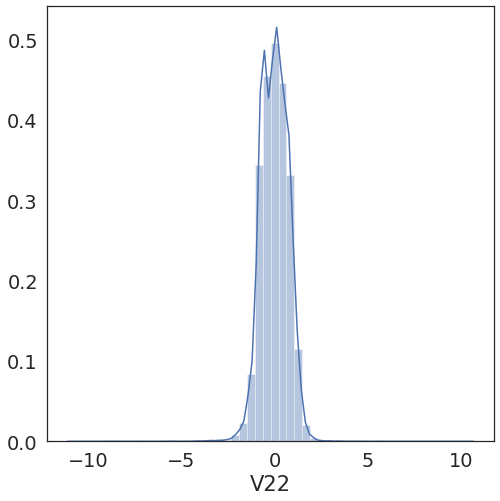

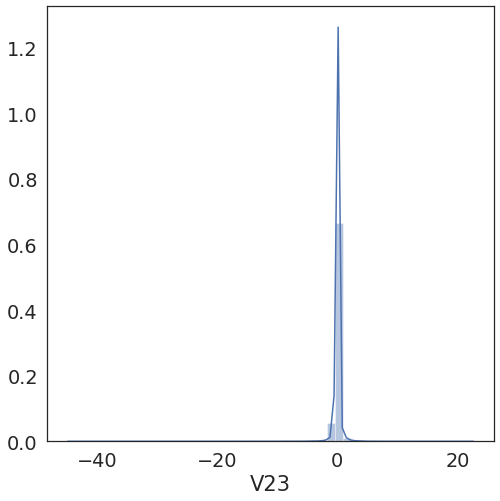

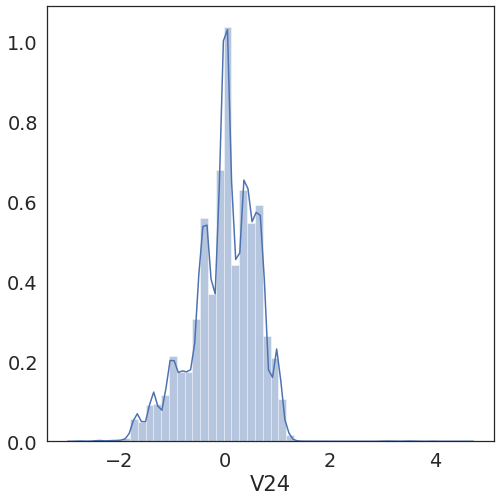

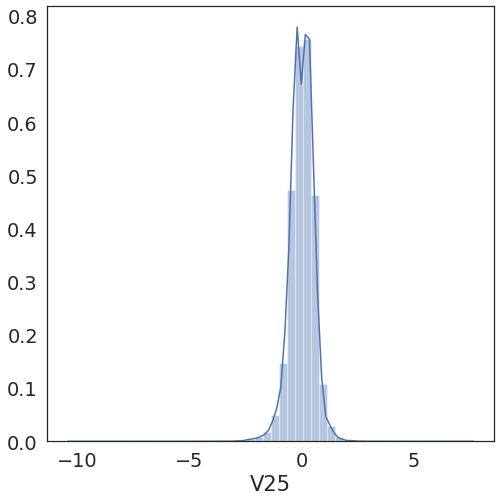

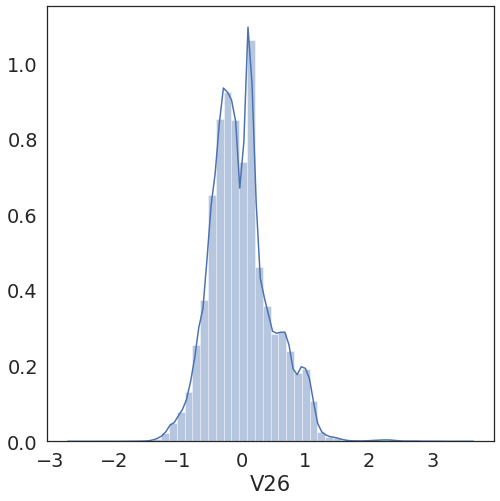

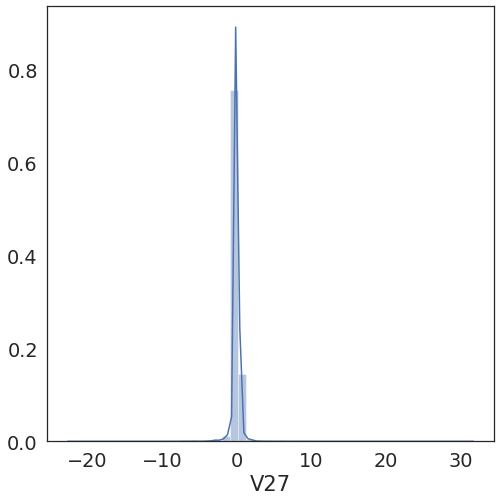

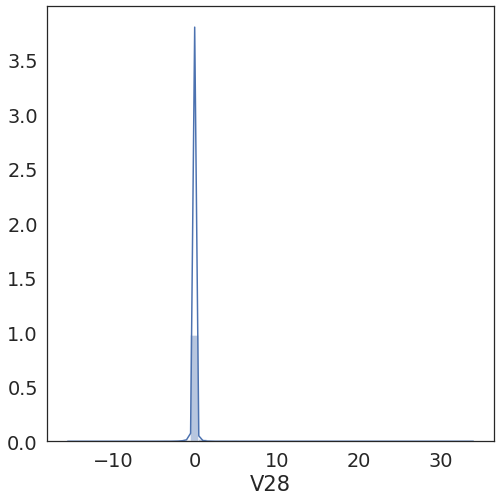

In [29]:
# Plot 2
for column in X.columns:
    plt.figure(figsize=(8,8))
    sns.distplot(X[column], bins=50)
plt.show()

In [30]:
# Plot 3: Same as plot 2 but shrunk
#fig = plt.figure(figsize = (18,18))
#ax = fig.gca()
#X.hist(ax=ax, bins=10)
#plt.show()

## Model Training and Testing
In this section we will be looking into the following: <br>
- A simple logistic regression
- Deep Neural Network based sigmoid classifier
- Unsupervised K-Means Clustering
- Unsupervised K-Means Clustering with PCA

### Logistic Regression

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [32]:
# normalize distribution of all features in dataframes
def normalize(x):
    x -= x.mean()
    x /= x.std()
    return x

#scale all numpy features
def scaling(x):
    return preprocessing.scale(x)

In [33]:
# I will be using normalize function on all the features before splitting
X = normalize(X)

In [34]:
# train test split
X_train = y_train = X_test = y_test = None
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_indices, test_indices in splitter.split(X, y):
    X_train, y_train = np.array(X.iloc[train_indices]), np.array(y.iloc[train_indices])
    X_test, y_test = np.array(X.iloc[test_indices]), np.array(y.iloc[test_indices])

In [35]:
# Model 1: Simple Logistic Regression using scikit-learn
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
y_pred = logistic_model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Logistic Model Score: ',logistic_model.score(X_test, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.57      0.70        98

    accuracy                           1.00     56962
   macro avg       0.96      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Logistic Model Score:  0.9991748885221726


As you can see, a simple logistic regression model give's us 99% accuracy. Or could it be overfitting.<br>
Let's try a Deep Learning approach and constrain it to stop training at loss lower than 0.01.

### Deep Neural Network based Sigmoid Classifier

In [37]:
# Model 2: Let's build a neural network classifier
import tensorflow as tf
tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_shape=(X_train.shape[1],), units=32, activation='relu', name='input_layer'),
    tf.keras.layers.Dense(units=64, activation='relu', name='hidden_layer_1'),
    tf.keras.layers.Dense(units=1, activation='sigmoid', name='output_layer')
])
tf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# loss='sparse_categorical_crossentropy' in case the output layer is a softmax

In [38]:
tf_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 32)                992       
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                2112      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________


In [39]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.01):  # You can also use logs.get('acc')>C where C is any value of accuracy [0,1]
            print('\nStopping training as required criteria (loss<0.01) has been met!')
            self.model.stop_training=True

In [40]:
callbacks=myCallback()
tf_model.fit(X_train, y_train, epochs=10, callbacks=[callbacks])

Epoch 1/10
227840/227845 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9979
Stopping training as required criteria (loss<0.01) has been met!
227845/227845 [==============================] - 28s 124us/step - loss: 0.0091 - acc: 0.9979


In [41]:
test_loss, test_acc = tf_model.evaluate(X_test, y_test)
print('Neural network model loss: {0}\t accuracy: {1}'.format(str(test_loss), str(test_acc)))

56962/56962 [==============================] - 2s 43us/step
Neural network model loss: 0.002863101581610726	 accuracy: 0.9994557775359011


Wow! These are great results.<br>
Most times we will not have labelled data. In such cases only unsupervised learning can be used. So in the next section let's see how we can apply Unsupervised K-means Clustering to our task.

### Unsupervised K-Means Clustering

In [42]:
# Model 3: Unsupervised using K-Means
from sklearn.cluster import KMeans

Let's visualize our data points using [Tensorflow Embedding Projector](https://projector.tensorflow.org/).

In [46]:
# Lets visualize the data using tensorflow embedding projector
import io
out_feats = io.open('vector.tsv', 'w', encoding='utf-8')
out_meta = io.open('meta.tsv', 'w', encoding='utf-8')
X_numpy = np.array(X)
y_numpy = np.array(y)
for i in range(len(X)):
    sample = X_numpy[i].tolist()
    sample = '\t'.join(map(str,sample))
    out_feats.write(sample+'\n')
    out_meta.write(str(y_numpy[i])+'\n')
out_feats.close()
out_meta.close()

![alt embedding_projector](embedding_projector.png "distribution")

![alt fraudulent](projector_fraud.png "Fraudulent")

Clearly it's not possible to draw a boundary around Non Fraudulent transactions excluding Fraudulent ones.

In [47]:
kmeans_model = KMeans(n_clusters=1)

In [48]:
kmeans_model.fit(X_train, y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [49]:
print(kmeans_model.cluster_centers_)
print(kmeans_model.labels_)

[[ 1.37249021e-03  1.76456911e-03  6.80204465e-04 -2.63527161e-03
  -8.23827709e-04  1.51226079e-04 -6.51290037e-04 -7.49447837e-04
  -3.15764973e-04 -6.58666204e-04  3.65010164e-04  7.39272296e-06
  -1.49703567e-03 -1.07658686e-03  1.05740660e-03  5.15143949e-05
  -2.86941734e-04 -1.41882760e-03 -1.20418169e-03  8.20428535e-04
  -2.60568871e-04  2.23699333e-03  4.81877683e-04  1.66294682e-03
   1.03467038e-03 -1.52213445e-03  2.00438415e-04  9.55732984e-04
   2.38720757e-05 -1.48512147e-03]]
[0 0 0 ... 0 0 0]


In [50]:
print('KMeans Model score for fraud detection: ',kmeans_model.score(X_test, y_test))

KMeans Model score for fraud detection:  -1694038.558250601


As expecting K-Means does not perform well at all.

### Unsupervised K-Means Clustering with PCA
Let's reduce the dimensionality of our feature vector to see if it helps.

In [51]:
# Lets apply PCA to reduce dimentionality of X
from sklearn.decomposition import PCA
pca = PCA(n_components=1, svd_solver='full')
pca_x_train = pca.fit_transform(X_train)
pca_x_train.shape

(227845, 1)

In [52]:
pca_x_test = pca.fit_transform(X_test)
pca_x_test.shape

(56962, 1)

In [53]:
kmeans_model_pca = KMeans(n_clusters=1)

In [54]:
kmeans_model_pca.fit(pca_x_train, y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [55]:
print('KMeans score with pca: ',kmeans_model_pca.score(pca_x_test, y_test))

KMeans score with pca:  -100767.42061616475


PCA does improve the performance but nowhere close to production level performance.

Before concluding, let's generate a logistic regression model with dimensionally reduced X to use it for the API demonstration of this project.

In [19]:
lr_pca_model = LogisticRegression()
lr_pca_model.fit(pca_x_train, y_train)
print('Logistic Regression score with pca: ',lr_pca_model.score(pca_x_test, y_test))

/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression score with pca:  0.9982795547909132


In [20]:
# Save Logistic Regression Model with PCA
import joblib
joblib.dump(lr_pca_model, 'models/lr_pca_model.joblib')

['models/lr_pca_model.joblib']

# That's all folks!